In [1]:
""" Importando as bibliotecas necessárias """

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import pinv, eigvals, inv
from scipy import linalg
from scipy.linalg import toeplitz as toeplitz
from scipy.signal import lfilter
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error as mse

In [2]:
class DeepESN:
    
    """ Inicialização de um objeto da classe DeepESN 
    
    Parâmetros: num_neuronios = número de neurônios por reservatório
                num_camadas =  número de camadas da rede (num_camadas >= 1)
                leaky_values = lista com os coeficientes de vazamento de cada camada
                spectral_radii = lista com os raios espectrais de cada camada
                scale_in = valor absoluto máximo aceito para os pesos de entrada
    """
    def __init__(self,num_neuronios,num_camadas,leaky_values,spectral_radii,scale_in):
        self.N = num_neuronios
        self.Nl = num_camadas
        self.a = leaky_values
        self.rho = spectral_radii
        self.win_max = scale_in
        
    """ Método fit: 
          * constrói as matrizes aleatórias do reservatório
          * computa a matriz com os estados da rede
          * obtém a matriz de pesos de saída através da solução de quadrados mínimos (pseudo-inversa)

          Parâmetros: u - matriz com os atributos de entrada de todos os padrões de treinamento (K x T + Tr)
                      d - matriz com as saídas desejadas (L x T)
                      Tr - número de amostras para o transitório (inicializar o vetor de estado)
    """

    def fit(self,u,d,Tr):

        
        #extrai o número de atributos de entrada e o número de padrões do conjunto de treinamento (com transitório)
        self.K,self.Tt = u.shape
        
        #número de padrões efetivos do conjunto de treinamento
        self.T = self.Tt - Tr
        
        #extrai o número de saídas da rede
        self.L = d.shape[0]
        
        """ Para cada camada l (de 1 a Nl), devemos determinar (1) a matriz de pesos de entrada (aleatória),
        (2) a matriz de pesos recorrentes, respeitando a condição de estados de eco, e (3) o vetor de estados (para
        todos os instantes de tempo) 
        Por simplicidade, vamos guardar estas informações em filas de comprimento Nl 
        """
        
        #inicializa as listas que vão guardar as matrizes de pesos Win, W
        self.Win = []
        self.W = []
        #inicializa a lista que vai guardar as matrizes com os estados de cada reservatório (para todos os instantes)
        self.X = []
        #inicializa a matriz que contém a concatenação dos estados dos reservatórios
        self.Xvec = np.zeros((self.N*self.Nl,self.T))
        
        for l in range(0,self.Nl):
            
            #inicializa a matriz com os estados do l-ésimo reservatório
            x_l = np.zeros((self.N,self.Tt+1))
            
            #número de entradas do reservatório l
            if (l == 0):
                Ne_l = self.K
                U = u
            else:
                Ne_l = self.N
                #a entrada da l-ésima camada é o vetor de saída da (l-1)-ésima camada (excluindo o estado inicial)
                U = np.delete(self.X[l-1],0,1)
            
            #matriz de pesos de entrada (Win) do reservatório l: N x Ne
            Win_l = 2*self.win_max*np.random.rand(self.N,Ne_l) - self.win_max
            self.Win.append(Win_l)
            
            #matriz de pesos recorrentes do reservatório l
        
            W_l = 2*np.random.rand(self.N,self.N) - 1
            Ws = (1-self.a[l])*np.eye(self.N) + self.a[l]*W_l
            max_v = max(abs(eigvals(Ws)))
            Ws = (self.rho[l]/max_v)*Ws
            W_l = (1/self.a[l])*(Ws - (1-self.a[l])*np.eye(self.N))
            self.W.append(W_l)
            
            #computa o estado do reservatório l para todos os instantes do conjunto de treinamento
            for i in range(0,self.Tt):
                
                x_l[:,i+1] = (1-self.a[l])*x_l[:,i] + self.a[l]*np.tanh(np.matmul(self.Win[l],U[:,i]) + np.matmul(self.W[l],x_l[:,i]))
                    
            self.X.append(x_l)
            
        for l in range(0,self.Nl):
            
            aux = self.X[l]
            """ elimina a primeira coluna (estado inicial com zeros) e os primeiros Tr estados (transitório)
                concatena a matriz de estados do reservatório l ao repositório completo """
            self.Xvec[l*self.N:(l+1)*self.N,:] = aux[:,Tr+1:]
        
        """ Agora, basta computar a pseudo-inversa da matriz Xvec para determinar os pesos da camada de saída """        
        self.Wout = np.matmul(pinv(self.Xvec.T),d[0,Tr:].T)
        self.Wout = self.Wout.T

        #saídas da rede para o conjunto de treinamento
        self.ytr = np.matmul(self.Wout,self.Xvec)

        return


    """ Método predict 
    
        Obtém as saídas da DeepESN para o conjunto de teste; as matrizes de pesos já estão prontas
    
    """
    def predict(self,ut,dt,Tr):
        
        #extrai o número de padrões do conjunto de teste
        self.nt = ut.shape[1]
        
        #inicializa a matriz com os estados concatenados (partimos do último estado observado no treinamento)
        self.Xvec_teste = np.zeros((self.N*self.Nl,self.nt-Tr))
        
        #inicializa a lista que vai guardar as matrizes com os estados de cada reservatório (para todos os instantes de teste)
        self.X_teste = []
        
        for l in range(0,self.Nl):
            
            #inicializa a matriz com os estados do l-ésimo reservatório (o estado inicial equivale ao último do treinamento)
            x_l = np.zeros((self.N,self.nt+1))
            Xl_aux = self.X[l]
            x_l[:,0] = Xl_aux[:,-1]
            
            if (l == 0):
                U = ut
            else:
                #a entrada da l-ésima camada é o vetor de saída da (l-1)-ésima camada (excluindo o estado inicial)
                U = self.X_teste[l-1]
            
            #computa o estado do reservatório l para todos os instantes do conjunto de teste
            for i in range(0,self.nt):
                
                x_l[:,i+1] = (1-self.a[l])*x_l[:,i] + self.a[l]*np.tanh(np.matmul(self.Win[l],U[:,i]) + np.matmul(self.W[l],x_l[:,i]))
                    
            #elimina a primeira coluna (estado inicial com zeros) 
            xt = np.delete(x_l,0,1)
            self.X_teste.append(xt)
        
        for l in range(0,self.Nl):
            #elimina os primeiros Tr estados (transitório)
            Xaux = self.X_teste[l]
            xt = np.delete(Xaux,np.arange(Tr),1)
            self.Xvec_teste[l*self.N:(l+1)*self.N,:] = xt
            
        #gera as saídas para o conjunto de teste
        self.yteste = np.matmul(self.Wout,self.Xvec_teste)

        return 


    

In [3]:
""" Rotina que gera os dados do problema de equalização supervisionada 
Entrada: canal - vetor com os coeficientes que definem a função de transf. do canal
               - Ex.: H(z) = 1.6 + z^{-1} --> canal = [1.6 1]
         SNR   - relação sinal-ruído em dB
         K     - número de amostras (atual e versões atrasadas) apresentadas na entrada da rede
         atraso - estabelece o atraso de equalização, i.e., qual a amostra passada da fonte que desejamos recuperar na saída do equalizador
                - Ex.: atraso = 0 --> o sinal desejado é a amostra s(n)
                - Ex.: atraso = 2 --> no instante n, o sinal desejado é s(n-2)
         T - número total de amostras do conjunto
Saída:   Y - vetor linha com as amostras desejadas para a saída da rede (1 x T)
         X - matriz (dimensão K x T) com as K amostras de entrada em cada instante de tempo """

def dados_equalizacao(canal,SNR,K,atraso,T):

    #variância do ruído
    sigma2 = sum(canal**2)*(10**(-SNR/10))

    #conjunto de treinamento
    s = np.sign(np.random.randn(1,T+atraso))
    #sinal recebido
    x = lfilter(canal,1,s) + np.sqrt(sigma2)*(np.random.randn(1,T+atraso))
    #sinal desejado: é a própria sequência de símbolos s(n)
    Y = s[0,0:T]
    #matriz de entrada do equalizador
    if (K > atraso + 1):
        #a primeira coluna é preenchida com zeros no final
        c = np.pad(x[0,atraso::-1],(0,K-atraso-1),'constant')
        X = toeplitz(c,x[0,atraso::1])
    elif K == atraso + 1:
        #pegamos exatamente as K (ou atraso + 1) primeiras amostras recebidas
        X = toeplitz(x[0,atraso::-1],x[0,atraso::1])
    else:
        #pegamos K amostras a partir do instante definido pelo atraso (e ainda assim não chegamos ao início do vetor)
        X = toeplitz(x[0,atraso:atraso-K:-1],x[0,atraso::1])
    
    Y = np.reshape(Y,(1,Y.size))
    return (X,Y)




In [4]:
""" Geração dos dados para treinamento e teste da DeepESN em equalização """

#número de amostras de treinamento
Ntr = 10000
#número de amostras de teste
Ntest = 10000
#número de amostras do transitório
Tr = 500

#Canal
h = np.array([0.5,1])
#Relação sinal-ruído (dB)
SNR = 30

#No. de amostras usadas para estimação do símbolo transmitido = número de entradas da rede
K = 1
#Atraso de equalização
atraso = 0

#cria os dados de treinamento e de teste
Xtr,ytr = dados_equalizacao(h,SNR,K,atraso,Ntr+Tr)
Xtest,ytest = dados_equalizacao(h,SNR,K,atraso,Ntest+Tr)


In [5]:
""" Teste de construção de uma DeepESN """

#número de reservatórios
Nl = 5

#número de neurônios em cada reservatório
Nn = 30

#lista com os raios espectrais
rho = [0.9,0.9,0.9,0.9,0.9,0.9]

#lista com os parâmetros de vazamento (leaky)
a = [1,1,1,1,1,1]

#escala dos pesos de entrada
win_max = 1

#cria um objeto da classe DeepESN
DESN = DeepESN(Nn,Nl,a,rho,win_max)



## Treinamento e teste da DESN

In [6]:
#efetua o treinamento da rede
DESN.fit(Xtr,ytr,Tr)

#realiza o teste da rede
DESN.predict(Xtest,ytest,Tr)

### Análise da DESN completa

- Saídas geradas para o conjunto de teste
- MSE 
- Taxa de erro
- Valores dos pesos do combinador linear da saída separados por reservatório

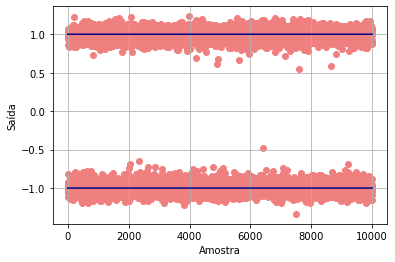

MSE de Teste da Rede Completa: 0.004599
BER de Teste da Rede Completa: 0.000000


,1,2,3,4,5
0,0.362966,-0.173108,0.174894,0.072316,-0.012594
1,-0.176865,-0.107299,-0.042840,0.103675,0.009770
2,0.168343,-0.580897,-0.041093,-0.061719,0.025312
3,-0.269869,-0.078597,0.040057,-0.017344,0.006928
4,0.424195,0.075894,-0.058540,-0.029037,0.035412
5,-0.298680,-0.075702,-0.032307,-0.006510,0.037197
6,0.242080,-0.000602,0.016855,-0.039736,0.066902
7,0.493974,-0.013008,0.098832,0.005605,-0.020607
8,-0.750029,-0.131257,-0.125245,-0.006204,0.052957
9,0.475386,0.080043,-0.101633,-0.004605,-0.052684


In [7]:
""" Saídas para o conjunto de teste """
plt.figure()
plt.plot(np.arange(0,ytest.size-Tr),np.ones((ytest.size-Tr)),c='darkblue')
plt.plot(np.arange(0,ytest.size-Tr),-1*np.ones((ytest.size-Tr)),c='darkblue')
plt.scatter(np.arange(0,ytest.size-Tr),DESN.yteste,c='lightcoral')
plt.grid(True)
plt.xlabel('Amostra')
plt.ylabel('Saída')
plt.show()

""" Desempenho """
MSE_TESTE = mse(ytest[0,Tr:],DESN.yteste)
BER_TESTE = distance.hamming(ytest[0,Tr:],np.sign(DESN.yteste))

print("MSE de Teste da Rede Completa: %f" %MSE_TESTE)
print("BER de Teste da Rede Completa: %f" %BER_TESTE)

""" Exibição dos pesos de saída associados a cada reservatório """

wol = np.reshape(DESN.Wout,(Nn,Nl),order='F')
df_wout = pd.DataFrame(wol, columns = np.arange(1,Nl+1))
#Exibe o DataFrame
df_wout


### Análise de cada reservatório da DESN

* Saídas produzidas pelo combinador linear ótimo quando apenas o estado do $l$-ésimo reservatório é usado
* MSE e taxa de erro referentes a cada reservatório (individualmente)

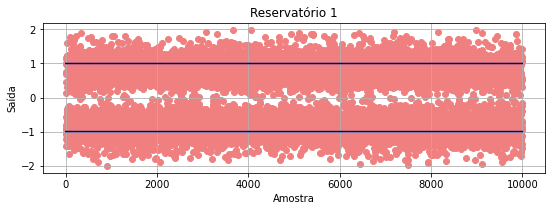

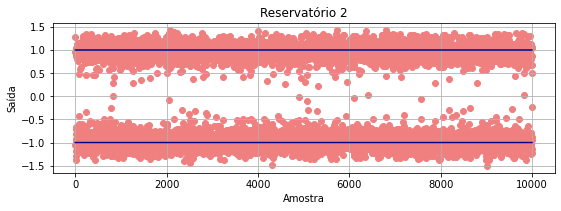

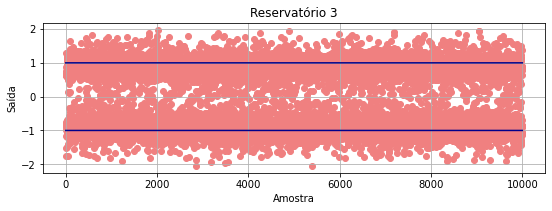

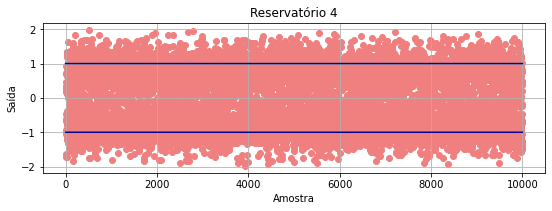

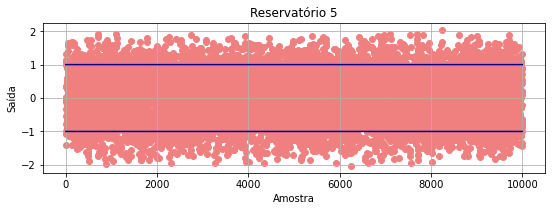

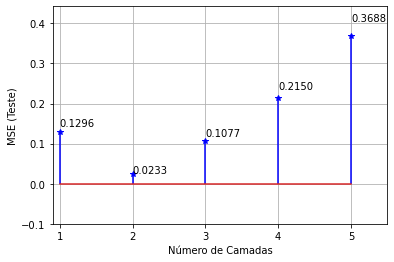

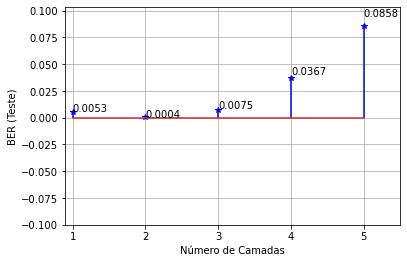

,1,2,3,4,5
0,-3.402035,-0.206477,-0.178751,0.640572,-0.000008
1,5.650186,-0.419813,0.276276,0.250029,-0.146051
2,-0.816205,-0.863180,-0.211314,-0.410602,-0.560573
3,1.045709,-0.190494,0.250051,-0.472235,-0.534681
4,0.320563,-0.165455,-0.462531,-0.098871,-0.114055
5,0.931372,0.055064,-0.261366,-0.385606,0.083616
6,1.523481,-0.230731,-0.407281,-0.652481,-0.238236
7,4.184078,0.168290,0.102933,-0.246107,0.004048
8,-1.685489,0.114996,0.199854,-0.435791,0.137896
9,1.014969,-0.241055,-0.525578,-0.187705,0.455058


In [8]:
""" Análise da qualidade de cada reservatório

* Para cada camada l, calculamos os pesos ótimos do combinador linear de saída e medimos o desempenho;
assim, podemos ter uma ideia do quanto de informação ainda há em cada camada.

"""

Wo = []
MSE_l = np.zeros((1,Nl))
BER_l = np.zeros((1,Nl))
pp = pd.DataFrame()

for l in range(0,Nl):
    
    """ DADOS DE TREINAMENTO """
    #extraímos a matriz completa com o estado do reservatório l
    xl = DESN.X[l]
    #elimina a primeira coluna (estado inicial) e os primeiros Tr estados (transitório)     
    XX = xl[:,Tr+1:]
    #obtemos a matriz de pesos que melhor aproveita o reservatório l e estima a saída desejada """        
    Wo.append(np.matmul(pinv(XX.T),ytr[0,Tr:].T))
    #guardamos a matriz de pesos de saída de cada reservatório também em um DataFrame
    pp.insert(l,l+1,Wo[l])
    
    """ DADOS DE TESTE E VERIFICAÇÃO DE DESEMPENHO """
    xl_teste = DESN.X_teste[l]
    #remoção dos primeiros Tr estados (transitório)
    xl_teste = np.delete(xl_teste,np.arange(Tr),1)
    #obtenção das saídas geradas pelo combinador linear associado à camada l
    yl_teste = np.matmul(Wo[l].T,xl_teste)
    #MSE correspondente à camada l
    MSE_l[0,l] = mse(ytest[0,Tr:],yl_teste)
    BER_l[0,l] = distance.hamming(ytest[0,Tr:],np.sign(yl_teste))
    
    fig = plt.figure(figsize=(9,16))
    plt.subplot(Nl,1,l+1)
    plt.plot(np.arange(0,ytest.size-Tr),np.ones((ytest.size-Tr)),c='darkblue')
    plt.plot(np.arange(0,ytest.size-Tr),-1*np.ones((ytest.size-Tr)),c='darkblue')
    plt.scatter(np.arange(0,ytest.size-Tr),yl_teste,c='lightcoral')
    plt.grid(True)
    plt.xlabel('Amostra')
    plt.ylabel('Saída')
    plt.title('Reservatório %i'  %(l+1))

plt.show()
    
fig,ax1 = plt.subplots()
ax1.stem(np.arange(0,Nl)+1,MSE_l.T,linefmt='b',markerfmt='b*')
ax1.grid(True)
ax1.set_ylabel('MSE (Teste)')
ax1.set_xlabel('Número de Camadas')
for l in range(0,Nl):
    ax1.text(l+1,1.1*MSE_l[0,l],'%1.4f' % MSE_l[0,l])
ax1.set_ylim(-0.1,1.2*np.max(MSE_l))
ax1.set_xlim(0.9,1.1*Nl)
plt.show()

fig,ax1 = plt.subplots()
ax1.stem(np.arange(0,Nl)+1,BER_l.T,linefmt='b',markerfmt='b*')
ax1.grid(True)
ax1.set_ylabel('BER (Teste)')
ax1.set_xlabel('Número de Camadas')
for l in range(0,Nl):
    ax1.text(l+1,1.1*BER_l[0,l],'%1.4f' % BER_l[0,l])
ax1.set_ylim(-0.1,1.2*np.max(BER_l))
ax1.set_xlim(0.9,1.1*Nl)
plt.show()

""" Pesos ótimos do combinador linear projetado para cada camada individualmente """

pp

## Busca pelos melhores hiperparâmetros

- Número de neurônios nos reservatórios ($N_n$)
- Fator de vazamento ($a_l, l = 1, \ldots, N_l$)
- Raio espectral ($\rho_l, l = 1, \ldots, N_l$)
- Número de camadas ($N_l$)


In [57]:
""" Geração dos dados para treinamento, validação e teste da DeepESN em equalização """

#número de amostras de treinamento
Ntr = 10000
#número de amostras de validação
Nval = 10000
#número de amostras de teste
Ntest = 10000
#número de amostras do transitório
Tr = 500

#Canal
h = np.array([0.5,1])
#Relação sinal-ruído (dB)
SNR = 30

#No. de amostras usadas para estimação do símbolo transmitido = número de entradas da rede
K = 1
#Atraso de equalização
atraso = 0

#cria os dados de treinamento e de teste
Xtr,ytr = dados_equalizacao(h,SNR,K,atraso,Ntr+Tr)
Xval,yval = dados_equalizacao(h,SNR,K,atraso,Nval+Tr)
Xtest,ytest = dados_equalizacao(h,SNR,K,atraso,Ntest+Tr)

""" Busca em grade pelos melhores hiperparâmetros da DESN """

#quantidade de camadas
Nl = [2,3,4]
#número de neurônios nas camadas
Nn = [10,50,100]
#raio espectral (comum a todas as camadas)
rho = [0.1,0.5,0.8,0.9,0.95]
#fator de vazamento (comum a todas as camadas)
leaking = [0.2,0.5,0.9,1]
#escala dos pesos de entrada
win_max = 1

#número de repetições independentes para a mesma combinação de valores dos hiperparâmetros
N_exp = 5

#inicialização
AMSE_val = np.zeros((len(Nl),len(Nn),len(rho),len(leaking)))
ABER_val = np.zeros((len(Nl),len(Nn),len(rho),len(leaking)))
MSE = []
BER = []
min_val = 1e10

""" (l,n,r,a,i):    l - índice que varre as possíveis quantidades de camadas 
                    n - índice que varre as possíveis quantidades de neurônios
                    r - índice que varre os possíveis valores para o raio espectral
                    a - índice que varre os possíveis valores para o fator de vazamento
                    i - índice associado ao experimento (repetição) independente     
"""

for l in range(0,len(Nl)):
  for n in range(0,len(Nn)):
    for r in range(0,len(rho)):
        #criar a lista com todos os valores de rho para as Nl[i] camadas (ou já para o número máximo de camadas)
        rho_list = np.ones((Nl[l],1))*rho[r]
        for a in range(0,len(leaking)):
            #criar a lista com cópias do valor de leaking[m] com tamanho igual ao número máximo de camadas
            a_list = np.ones((Nl[l],1))*leaking[a]
            #cria um objeto da classe DeepESN
            DESN = DeepESN(Nn[n],Nl[l],rho_list,a_list,win_max)
            
            for i in range(0,N_exp):
                #efetua o treinamento da rede
                DESN.fit(Xtr,ytr,Tr)
                #avalia o desempenho da rede nos dados de validação
                DESN.predict(Xval,yval,Tr)
                #guardar os MSEs das repetições
                MSE.append(mse(yval[0,Tr:],DESN.yteste))
                BER.append(distance.hamming(yval[0,Tr:],np.sign(DESN.yteste)))
        
            #calculamos o MSE médio para as N_exp repetições
            AMSE_val[l,n,r,a] = np.mean(MSE)
            ABER_val[l,n,r,a] = np.mean(BER)
            #reiniciamos a lista de MSE para 
            MSE = []
            BER = []
            
            if AMSE_val[l,n,r,a] < min_val:
                imin = [l,n,r,a]
                min_val = AMSE_val[l,n,r,a]
                
            
#Combinação de parâmetros que gerou o melhor resultado de validação
Nn_o = Nn[imin[1]]
Nl_o = Nl[imin[0]]
rho_o = rho[imin[2]]
a_o = leaking[imin[3]]

print("Número de camadas: %d" %Nl_o)
print("Número de neurônios: %d" %Nn_o)
print("Raio espectral: %1.2f" %rho_o)
print("Fator de vazamento: %1.2f" %a_o)
print("AMSE de validação: %f" %min_val)
print("ABER de validação: %f" %ABER_val[imin[0],imin[1],imin[2],imin[3]])


Número de camadas: 4
Número de neurônios: 100
Raio espectral: 0.95
Fator de vazamento: 0.20
AMSE de validação: 0.000000
ABER de validação: 0.000000


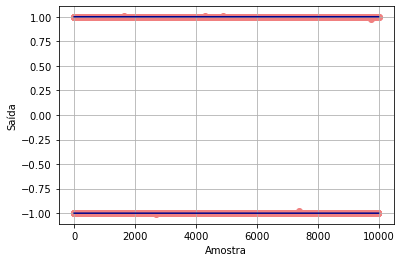

MSE de Teste da Rede Completa: 0.000000
BER de Teste da Rede Completa: 0.000000


In [59]:
""" Análise da DESN ótima para o conjunto de teste """

#lista com os ótimos valores de rho e a
a_list_o = np.ones((Nl_o,1))*a_o
rho_list_o = np.ones((Nl_o,1))*rho_o

#cria um objeto da classe DeepESN
DESN = DeepESN(Nn_o,Nl_o,rho_list_o,a_list_o,win_max)
#efetua o treinamento da rede
DESN.fit(Xtr,ytr,Tr)
#avalia o desempenho da rede nos dados de validação
DESN.predict(Xtest,ytest,Tr)

""" Saídas para o conjunto de teste """
plt.figure()
plt.plot(np.arange(0,ytest.size-Tr),np.ones((ytest.size-Tr)),c='darkblue')
plt.plot(np.arange(0,ytest.size-Tr),-1*np.ones((ytest.size-Tr)),c='darkblue')
plt.scatter(np.arange(0,ytest.size-Tr),DESN.yteste,c='lightcoral')
plt.grid(True)
plt.xlabel('Amostra')
plt.ylabel('Saída')
plt.show()

""" Desempenho """
MSE_TESTE = mse(ytest[0,Tr:],DESN.yteste)
BER_TESTE = distance.hamming(ytest[0,Tr:],np.sign(DESN.yteste))

print("MSE de Teste da Rede Completa: %f" %MSE_TESTE)
print("BER de Teste da Rede Completa: %f" %BER_TESTE)


## Comparação com uma ESN padrão com um único reservatório

In [65]:
""" Busca em grade pelos melhores hiperparâmetros da DESN """

#número de neurônios no reservatório único
Nesn = Nn_o*Nl_o
#raio espectral 
rho_esn = np.linspace(0.1,0.99,20)
#fator de vazamento 
a_esn = np.linspace(0.1,1,20)
#escala dos pesos de entrada
win_max = 1

#número de repetições independentes para a mesma combinação de valores dos hiperparâmetros
N_exp = 5

#inicialização
AMSE_val_esn = np.zeros((rho_esn.size,a_esn.size))
ABER_val_esn = np.zeros((rho_esn.size,a_esn.size))
MSE = []
BER = []
min_val_esn = 1e10

""" (r,k,i):    r - índice que varre os possíveis valores para o raio espectral
                k - índice que varre os possíveis valores para o fator de vazamento
                i - índice associado ao experimento (repetição) independente     
"""
rho_esn_list = []
a_esn_list = []

for r in range(0,rho_esn.size):
    
    rho_esn_list.append(rho_esn[r])
    
    for k in range(0,a_esn.size):
        
        a_esn_list.append(a_esn[k])
        
        #cria um objeto da classe DeepESN
        DESN = DeepESN(Nesn,1,rho_esn_list,a_esn_list,win_max)
        
        for i in range(0,N_exp):
            #efetua o treinamento da rede
            DESN.fit(Xtr,ytr,Tr)
            #avalia o desempenho da rede nos dados de validação
            DESN.predict(Xval,yval,Tr)
            #guardar os MSEs das repetições
            MSE.append(mse(yval[0,Tr:],DESN.yteste))
            BER.append(distance.hamming(yval[0,Tr:],np.sign(DESN.yteste)))
        
        #calculamos o MSE médio para as N_exp repetições
        AMSE_val_esn[r,k] = np.mean(MSE)
        ABER_val_esn[r,k] = np.mean(BER)
        #reiniciamos a lista de MSE para 
        MSE = []
        BER = []
        a_esn_list = []
        
        if AMSE_val_esn[r,k] < min_val_esn:
            imin_esn = [r,k]
            min_val_esn = AMSE_val_esn[r,k]
    
    rho_esn_list = []
                
#Combinação de parâmetros que gerou o melhor resultado de validação
rho_esn_o = rho_esn[imin_esn[0]]
a_esn_o = a_esn[imin_esn[1]]

print("Raio espectral: %1.2f" %rho_esn_o)
print("Fator de vazamento: %1.2f" %a_esn_o)
print("AMSE de validação: %f" %min_val_esn)
print("ABER de validação: %f" %ABER_val_esn[imin_esn[0],imin_esn[1]])

Raio espectral: 0.99
Fator de vazamento: 0.10
AMSE de validação: 0.000002


IndexError: index 19 is out of bounds for axis 0 with size 3